In [1]:
import pandas as pd 
import geopandas as geopd

import os

try:# has been imported
    from whitebox.WBT.whitebox_tools import WhiteboxTools
except: #hasn't been imported previously
    from whitebox.whitebox_tools import WhiteboxTools

from tqdm.notebook import tqdm

In [2]:
wbt = WhiteboxTools()
wbt.set_verbose_mode(False)

catchments_path = "/home/iielse/Documents/DIWA/data/CAMELS-FI catchments/CAMELS-FI_basins.gpkg"
catchments = geopd.read_file(catchments_path, layer='v1')
catchments = catchments.reset_index(names=['dem_id'])


gauge_path = "/home/iielse/Documents/DIWA/data/omat digitoinnit/CAMELS-FI flow gauges.gpkg"
gauges = geopd.read_file(gauge_path, layer="attributes_v1")
gauges = geopd.sjoin(gauges[['gauge_id', 'geometry']], catchments[['dem_id', 'geometry']], how='left')
gauges = gauges.drop('index_right', axis=1)

In [3]:
gauges

,gauge_id,geometry,dem_id
0,996,POINT (426439 6942209),1
1,1003,POINT (483700 6986943),1
2,1008,POINT (465119 6942164),1
3,1009,POINT (460520 6935084),1
4,1012,POINT (457286 6916818),1
...,...,...,...
315,961,POINT (583582.115 6937848.657),17
316,964,POINT (534007 6924481),56
317,1369,POINT (492240 7361571),0
318,1366,POINT (497774 7355695),0


In [4]:
root = "/media/iielse/T9/gisT7/korkeusmalli_10_m"
#root = '/home/iiro/980/GIS980/korkeusmalli_10_m'

stream_dir = os.path.join(root, "stream_thresholding")

tmp_dir = "/tmp/stream_processing"
if not os.path.isdir(tmp_dir):
        os.mkdir(tmp_dir)

point_tmp_path = os.path.join(tmp_dir, "pour_points.shp")
snapped_tmp_path = os.path.join(tmp_dir, "snapped_points.shp")


snapped_locations = []
with tqdm(catchments.iterrows(), total=len(catchments)) as pbar:
    for i, catchment in pbar:
        locations = gauges.loc[gauges['dem_id'] == i]
        counter = 0

        for j, location in locations.iterrows():
            counter += 1
            pbar.set_description(f"processing pour point {counter}/{len(locations)} of catchment {i}")

             # Converting from series to GeoDataFrame
            location = geopd.GeoDataFrame(
                    dict(zip(list(location.index), list(location.values))),
                    crs=locations.crs, geometry='geometry', index=[0])
            
            stream_path = os.path.join(stream_dir, f"stream_thresholding_{i}.tif")
            location.to_file(point_tmp_path)
            wbt.jenson_snap_pour_points(point_tmp_path, stream_path, snapped_tmp_path, 500)
            snapped_locations.append(geopd.read_file(snapped_tmp_path))

  0%|          | 0/74 [00:00<?, ?it/s]

In [17]:
snapped = pd.concat(snapped_locations)
snapped = snapped.reset_index(drop=True)

<Axes: >

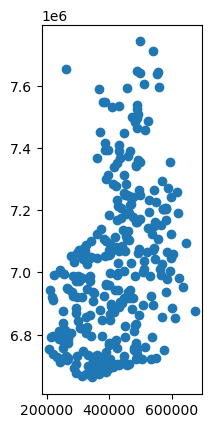

In [18]:
snapped.plot()

In [23]:
snapped.to_file("/home/iielse/Documents/DIWA/data/omat digitoinnit/CAMELS-FI flow gauges.gpkg", driver='GPKG', layer='snapped')

In [21]:
snapped

,gauge_id,dem_id,geometry
0,2739,0,POINT (489184.91 7496587.245)
1,2740,0,POINT (482704.914 7482197.084)
2,3727,0,POINT (485784.912 7343165.529)
3,3728,0,POINT (484364.913 7344875.548)
4,1351,0,POINT (489524.91 7538637.715)
...,...,...,...
315,3264,69,POINT (457385 6703365)
316,1390,70,POINT (262125 7652515)
317,938,71,POINT (508815 6999975)
318,952,72,POINT (531575 6988205)
